# 对比直接用机器学习模拟参数，和留一验证参数预估结果

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import os
import sys
import time
import xarray as xr
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Water_Blance_Model import mYWBMnlS, abcdnlS, DWBMnlS
from Rewrite_Func import nash_sutcliffe_efficiency, relative_error, kling_gupta_efficiency
from numba import float64, njit
from numba.experimental import jitclass
from netCDF4 import Dataset
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from scipy.ndimage import median_filter
from concurrent.futures import ThreadPoolExecutor, as_completed

# 定义流域信息

In [2]:
# 读取流域信息
basin_info      = pd.read_excel('../../Data/Basin_Selection/All_Selected_Basins.xlsx')
basin_list      = basin_info['stat_num']
cali_start_list = basin_info['cali_start']
cali_end_list   = basin_info['cali_end']
vali_start_list = basin_info['vali_start']
vali_end_list   = basin_info['vali_end']

# 获取流域属性

In [3]:
Basin_Properties = pd.read_csv("../../Data/Properties/Basin_Properties.txt", sep = '\t', header=0, index_col='stat_num')

# 获取率定参数

In [4]:
params_mYWBM_cali   = pd.read_csv("../../Data/Params/03_mYWBM_Best_Params_CF.txt", sep = '\t', header=0, index_col='stat_num')
params_abcd_cali    = pd.read_csv("../../Data/Params/03_abcd_Best_Params_CF.txt", sep = '\t', header=0, index_col='stat_num')
params_DWBM_cali    = pd.read_csv("../../Data/Params/03_DWBM_Best_Params_CF.txt", sep = '\t', header=0, index_col='stat_num')

# 获取留一验证参数

In [5]:
params_YM_rf_leave_one  = pd.read_csv("../../Results/Params_Transplant/mYWBM_RF_Params.txt", sep = '\t', header=0, index_col=0)
params_YM_svm_leave_one = pd.read_csv("../../Results/Params_Transplant/mYWBM_SVM_Params.txt", sep = '\t', header=0, index_col=0)
params_YM_xgb_leave_one = pd.read_csv("../../Results/Params_Transplant/mYWBM_XGB_Params.txt", sep = '\t', header=0, index_col=0)

params_AM_rf_leave_one  = pd.read_csv("../../Results/Params_Transplant/abcd_RF_Params.txt", sep = '\t', header=0, index_col=0)
params_AM_svm_leave_one = pd.read_csv("../../Results/Params_Transplant/abcd_SVM_Params.txt", sep = '\t', header=0, index_col=0)
params_AM_xgb_leave_one = pd.read_csv("../../Results/Params_Transplant/abcd_XGB_Params.txt", sep = '\t', header=0, index_col=0)

params_DM_rf_leave_one  = pd.read_csv("../../Results/Params_Transplant/DWBM_RF_Params.txt", sep = '\t', header=0, index_col=0)
params_DM_svm_leave_one = pd.read_csv("../../Results/Params_Transplant/DWBM_SVM_Params.txt", sep = '\t', header=0, index_col=0)
params_DM_xgb_leave_one = pd.read_csv("../../Results/Params_Transplant/DWBM_XGB_Params.txt", sep = '\t', header=0, index_col=0)

# 机器学习回归模型

In [6]:
def train_random_forest(basin_properties_scaled, params):
    """
    训练随机森林回归模型（多目标回归）
    
    参数：
    - basin_properties_scaled: 所有流域的标准化后的属性，包含19个属性 (numpy 数组或 pandas DataFrame)
    - params: 所有流域的参数 (numpy 数组或 pandas DataFrame)
    
    返回：
    - trained_rf_model: 训练好的随机森林回归模型
    """
    # 初始化并训练模型
    rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators      = 100, 
                                                          max_depth         = 10,
                                                          min_samples_split = 5,
                                                          min_samples_leaf  = 2,
                                                          random_state      = 42,
                                                          n_jobs            = -1), n_jobs=-1)
    rf_model.fit(basin_properties_scaled, params)
    
    return rf_model

def train_svm(basin_properties_scaled, params):
    """
    训练支持向量回归模型（多目标回归）
    
    参数：
    - basin_properties_scaled: 所有流域的标准化后的属性，包含19个属性 (numpy 数组或 pandas DataFrame)
    - params: 所有流域的参数 (numpy 数组或 pandas DataFrame)
    
    返回：
    - trained_svm_model: 训练好的支持向量机回归模型
    """    
    # 初始化并训练模型
    svr_model = MultiOutputRegressor(SVR(kernel     = 'rbf',
                                         C          = 100,
                                         epsilon    = 0.01,
                                         gamma      = 0.1), n_jobs=-1)
    svr_model.fit(basin_properties_scaled, params)
    
    return svr_model

def train_xgboost(basin_properties_scaled, params):
    """
    训练XGBoost回归模型（多目标回归）
    
    参数：
    - basin_properties_scaled: 所有流域的标准化后的属性，包含19个属性 (numpy 数组或 pandas DataFrame)
    - params: 所有流域的参数 (numpy 数组或 pandas DataFrame)
    
    返回：
    - trained_xgb_model: 训练好的XGBoost回归模型
    """
    # 初始化并训练模型
    xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators      = 100,
                                                  learning_rate     = 0.1,
                                                  max_depth         = 6,
                                                  min_child_weight  = 3,
                                                  gamma             = 0.1,
                                                  colsample_bytree  = 0.8,
                                                  subsample         = 0.8,
                                                  reg_alpha         = 0.1,
                                                  random_state      = 42,
                                                  n_jobs            = -1), n_jobs=-1)
    xgb_model.fit(basin_properties_scaled, params)
    
    return xgb_model

def get_params_by_regression(target_properties_scaled, trained_models):
    """
    使用训练好的回归模型根据目标流域的属性预测多个参数。
    
    参数：
    - target_properties_scaled: 目标流域的标准化后的属性 (1x19 numpy 数组或 pandas Series)
    - model: 训练好的回归模型（可以是随机森林、支持向量机或XGBoost）
    - scaler: 用于标准化的Scaler
    
    返回：
    - predicted_params: 模型预测的多个参数
    """
    # 使用模型进行预测
    predicted_params = trained_models.predict(target_properties_scaled)
    return np.squeeze(predicted_params)

# 利用所有数据训练机器学习模型

In [7]:
def clean_params(params, all_params, lower_bound, upper_bound):
    r, c = params.shape
    for i in range(r):
        for j in range(c):
            if params[i, j] < lower_bound[j] or params[i, j] > upper_bound[j]:
                params[i, j] = np.nanmean(all_params[:, j])
    return params

In [14]:
scaler = StandardScaler()
source_properties = Basin_Properties[['Climate', 'Clay', 'Silt', 'Sand', 'Slope', 'BFI', 'PRE', 'TMP', 'PET', 'TMAX', 'TMIN', 'AE', 'NDVI', 'TI']].values
source_properties_scaled = scaler.fit_transform(source_properties)

rf_model_YM  = train_random_forest(source_properties_scaled, params_mYWBM_cali.values)
svm_model_YM = train_svm(source_properties_scaled, params_mYWBM_cali.values)
xgb_model_YM = train_xgboost(source_properties_scaled, params_mYWBM_cali.values)

rf_model_AM  = train_random_forest(source_properties_scaled, params_abcd_cali.values)
svm_model_AM = train_svm(source_properties_scaled, params_abcd_cali.values)
xgb_model_AM = train_xgboost(source_properties_scaled, params_abcd_cali.values)

rf_model_DM  = train_random_forest(source_properties_scaled, params_DWBM_cali.values)
svm_model_DM = train_svm(source_properties_scaled, params_DWBM_cali.values)
xgb_model_DM = train_xgboost(source_properties_scaled, params_DWBM_cali.values)

In [17]:
pred_params_rf_YM  = clean_params(get_params_by_regression(source_properties_scaled, rf_model_YM), params_mYWBM_cali.values, [0, 0, 0.05, 100, 0], [1, 0.65, 0.95, 1000, 1])
pred_params_svr_YM = clean_params(get_params_by_regression(source_properties_scaled, svm_model_YM), params_mYWBM_cali.values, [0, 0, 0.05, 100, 0], [1, 0.65, 0.95, 1000, 1])
pred_params_xgb_YM = clean_params(get_params_by_regression(source_properties_scaled, xgb_model_YM), params_mYWBM_cali.values, [0, 0, 0.05, 100, 0], [1, 0.65, 0.95, 1000, 1])

pred_params_rf_AM  = clean_params(get_params_by_regression(source_properties_scaled, rf_model_AM), params_abcd_cali.values, [0, 100, 0, 0, 0], [1, 2000, 1, 1, 1])
pred_params_svr_AM = clean_params(get_params_by_regression(source_properties_scaled, svm_model_AM), params_abcd_cali.values, [0, 100, 0, 0, 0], [1, 2000, 1, 1, 1])
pred_params_xgb_AM = clean_params(get_params_by_regression(source_properties_scaled, xgb_model_AM), params_abcd_cali.values, [0, 100, 0, 0, 0], [1, 2000, 1, 1, 1])

pred_params_rf_DM  = clean_params(get_params_by_regression(source_properties_scaled, rf_model_DM), params_DWBM_cali.values, [0, 0, 100, 0, 0], [1, 1, 2000, 1, 1])
pred_params_svr_DM = clean_params(get_params_by_regression(source_properties_scaled, svm_model_DM), params_DWBM_cali.values, [0, 0, 100, 0, 0], [1, 1, 2000, 1, 1])
pred_params_xgb_DM = clean_params(get_params_by_regression(source_properties_scaled, xgb_model_DM), params_DWBM_cali.values, [0, 0, 100, 0, 0], [1, 1, 2000, 1, 1])

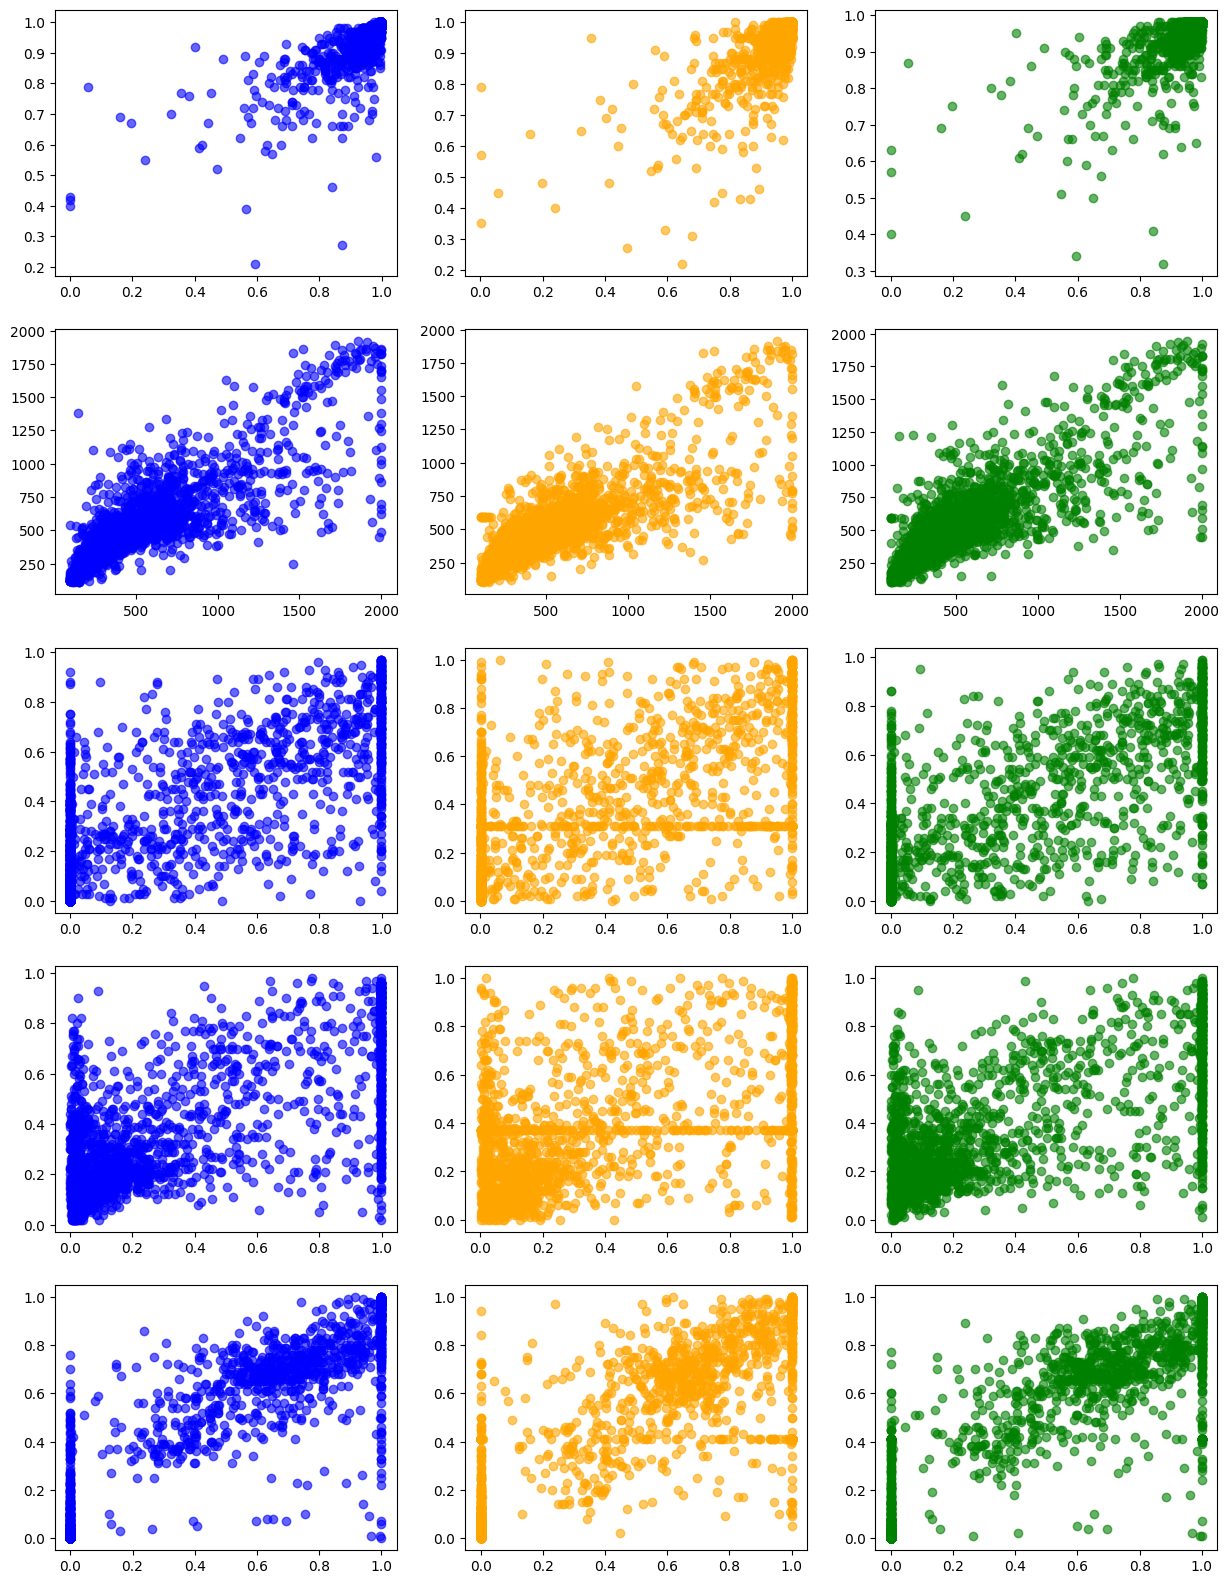

In [20]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

ax[0, 0].scatter(params_abcd_cali.values[:, 0], params_AM_rf_leave_one.values[:, 0], c='blue', label='RF', alpha=0.6)
ax[1, 0].scatter(params_abcd_cali.values[:, 1], params_AM_rf_leave_one.values[:, 1], c='blue', label='RF', alpha=0.6)
ax[2, 0].scatter(params_abcd_cali.values[:, 2], params_AM_rf_leave_one.values[:, 2], c='blue', label='RF', alpha=0.6)
ax[3, 0].scatter(params_abcd_cali.values[:, 3], params_AM_rf_leave_one.values[:, 3], c='blue', label='RF', alpha=0.6)
ax[4, 0].scatter(params_abcd_cali.values[:, 4], params_AM_rf_leave_one.values[:, 4], c='blue', label='RF', alpha=0.6)

ax[0, 1].scatter(params_abcd_cali.values[:, 0], params_AM_svm_leave_one.values[:, 0], c='orange', label='SVM', alpha=0.6)
ax[1, 1].scatter(params_abcd_cali.values[:, 1], params_AM_svm_leave_one.values[:, 1], c='orange', label='SVM', alpha=0.6)
ax[2, 1].scatter(params_abcd_cali.values[:, 2], params_AM_svm_leave_one.values[:, 2], c='orange', label='SVM', alpha=0.6)
ax[3, 1].scatter(params_abcd_cali.values[:, 3], params_AM_svm_leave_one.values[:, 3], c='orange', label='SVM', alpha=0.6)
ax[4, 1].scatter(params_abcd_cali.values[:, 4], params_AM_svm_leave_one.values[:, 4], c='orange', label='SVM', alpha=0.6)

ax[0, 2].scatter(params_abcd_cali.values[:, 0], params_AM_xgb_leave_one.values[:, 0], c='green', label='XGB', alpha=0.6)
ax[1, 2].scatter(params_abcd_cali.values[:, 1], params_AM_xgb_leave_one.values[:, 1], c='green', label='XGB', alpha=0.6)
ax[2, 2].scatter(params_abcd_cali.values[:, 2], params_AM_xgb_leave_one.values[:, 2], c='green', label='XGB', alpha=0.6)
ax[3, 2].scatter(params_abcd_cali.values[:, 3], params_AM_xgb_leave_one.values[:, 3], c='green', label='XGB', alpha=0.6)
ax[4, 2].scatter(params_abcd_cali.values[:, 4], params_AM_xgb_leave_one.values[:, 4], c='green', label='XGB', alpha=0.6)

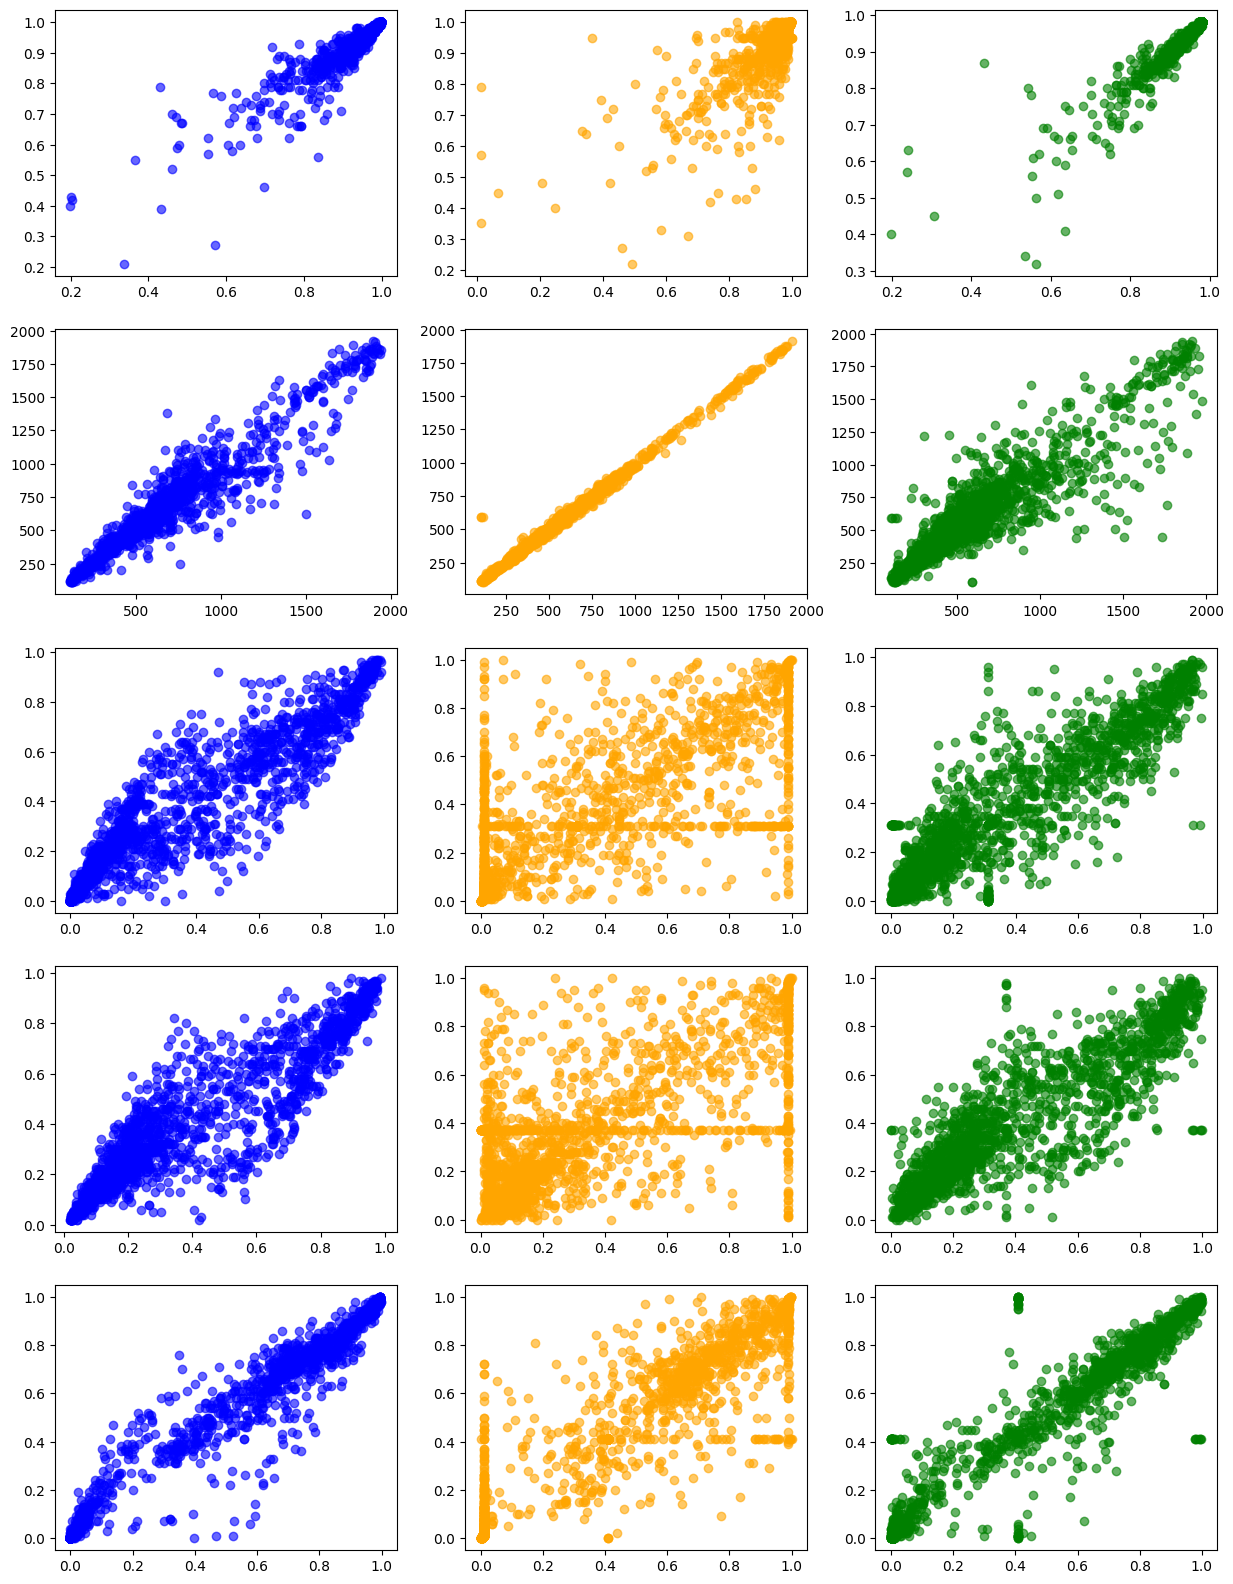

In [21]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

ax[0, 0].scatter(pred_params_rf_DM[:, 0], params_DM_rf_leave_one.values[:, 0], c='blue', label='RF', alpha=0.6)
ax[1, 0].scatter(pred_params_rf_DM[:, 1], params_DM_rf_leave_one.values[:, 1], c='blue', label='RF', alpha=0.6)
ax[2, 0].scatter(pred_params_rf_DM[:, 2], params_DM_rf_leave_one.values[:, 2], c='blue', label='RF', alpha=0.6)
ax[3, 0].scatter(pred_params_rf_DM[:, 3], params_DM_rf_leave_one.values[:, 3], c='blue', label='RF', alpha=0.6)
ax[4, 0].scatter(pred_params_rf_DM[:, 4], params_DM_rf_leave_one.values[:, 4], c='blue', label='RF', alpha=0.6)

ax[0, 1].scatter(pred_params_svr_DM[:, 0], params_DM_svm_leave_one.values[:, 0], c='orange', label='SVM', alpha=0.6)
ax[1, 1].scatter(pred_params_svr_DM[:, 1], params_DM_svm_leave_one.values[:, 1], c='orange', label='SVM', alpha=0.6)
ax[2, 1].scatter(pred_params_svr_DM[:, 2], params_DM_svm_leave_one.values[:, 2], c='orange', label='SVM', alpha=0.6)
ax[3, 1].scatter(pred_params_svr_DM[:, 3], params_DM_svm_leave_one.values[:, 3], c='orange', label='SVM', alpha=0.6)
ax[4, 1].scatter(pred_params_svr_DM[:, 4], params_DM_svm_leave_one.values[:, 4], c='orange', label='SVM', alpha=0.6)

ax[0, 2].scatter(pred_params_xgb_DM[:, 0], params_DM_xgb_leave_one.values[:, 0], c='green', label='XGB', alpha=0.6)
ax[1, 2].scatter(pred_params_xgb_DM[:, 1], params_DM_xgb_leave_one.values[:, 1], c='green', label='XGB', alpha=0.6)
ax[2, 2].scatter(pred_params_xgb_DM[:, 2], params_DM_xgb_leave_one.values[:, 2], c='green', label='XGB', alpha=0.6)
ax[3, 2].scatter(pred_params_xgb_DM[:, 3], params_DM_xgb_leave_one.values[:, 3], c='green', label='XGB', alpha=0.6)
ax[4, 2].scatter(pred_params_xgb_DM[:, 4], params_DM_xgb_leave_one.values[:, 4], c='green', label='XGB', alpha=0.6)